# **Fine-Tuning Stable Diffusion Models with DreamBooth for Custom Image Generation**

# Setting Up the Workspace


## Setting Up Dependencies

In [ ]:
# Install necessary libraries and tools
!pip install -U -qq git+https://github.com/huggingface/diffusers.git
!pip install -qq transformers ftfy gradio accelerate tensorboard
!pip install -qq bitsandbytes
!pip install -qq "ipywidgets>=7,<8"
!pip install -U --pre triton


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.9 MB/s eta 0:00:00
     ━━━━━━

## Import libraries

In [ ]:
# Import necessary libraries
import argparse
from argparse import Namespace

import itertools
import math
import os
from contextlib import nullcontext
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
import accelerate
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import (AutoencoderKL, DDPMScheduler, PNDMScheduler,
                       StableDiffusionPipeline, UNet2DConditionModel,
                       DPMSolverMultistepScheduler)
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

import bitsandbytes as bnb

from subprocess import check_output
from IPython.display import display, clear_output
import time

import requests
import glob
from io import BytesIO

from pathlib import Path

import gc

import gradio as gr


## Function to create a grid of images


In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))

    return grid


## Install Xformers for Optimized Training

In [ ]:
# Optimizing Training with Xformers Installation

# Get the GPU type using nvidia-smi
gpu_info = check_output('nvidia-smi').decode('utf-8')
supported_gpus = {'T4', 'P100', 'V100', 'A100'}
gpu_type = next((gpu for gpu in supported_gpus if gpu in gpu_info), None)

# Verify if the detected GPU is supported
while gpu_type is None:
    print('\033[1;31mIt seems that your GPU is not supported at the moment')
    time.sleep(5)
    gpu_info = check_output('nvidia-smi').decode('utf-8')
    gpu_type = next((gpu for gpu in supported_gpus if gpu in gpu_info), None)

# Mapping of GPU types to xformers wheel URLs
xformers_wheel_urls = {
    'T4': 'https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl',
    'P100': 'https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/P100/xformers-0.0.13.dev0-py3-none-any.whl',
    'V100': 'https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/V100/xformers-0.0.13.dev0-py3-none-any.whl',
    'A100': 'https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/A100/xformers-0.0.13.dev0-py3-none-any.whl',
}

# Install the appropriate xformers wheel for the detected GPU
if gpu_type in xformers_wheel_urls:
    !pip install -q {xformers_wheel_urls[gpu_type]}


  ERROR: HTTP error 404 while getting https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl
ERROR: Could not install requirement xformers==0.0.13.dev0 from https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl because of HTTP error 404 Client Error: Not Found for url: https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl for URL https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl


# Preparing Training Settings for Concept Learning




## Select the pre-trained model


In [ ]:
pretrained_model_name_or_path = "stabilityai/stable-diffusion-2"


## URLs of images for training


In [ ]:
urls = [
    "https://huggingface.co/datasets/valhalla/images/resolve/main/2.jpeg",
    "https://huggingface.co/datasets/valhalla/images/resolve/main/3.jpeg",
    "https://huggingface.co/datasets/valhalla/images/resolve/main/5.jpeg",
    "https://huggingface.co/datasets/valhalla/images/resolve/main/6.jpeg",
]


## Setup and check the images you have just added

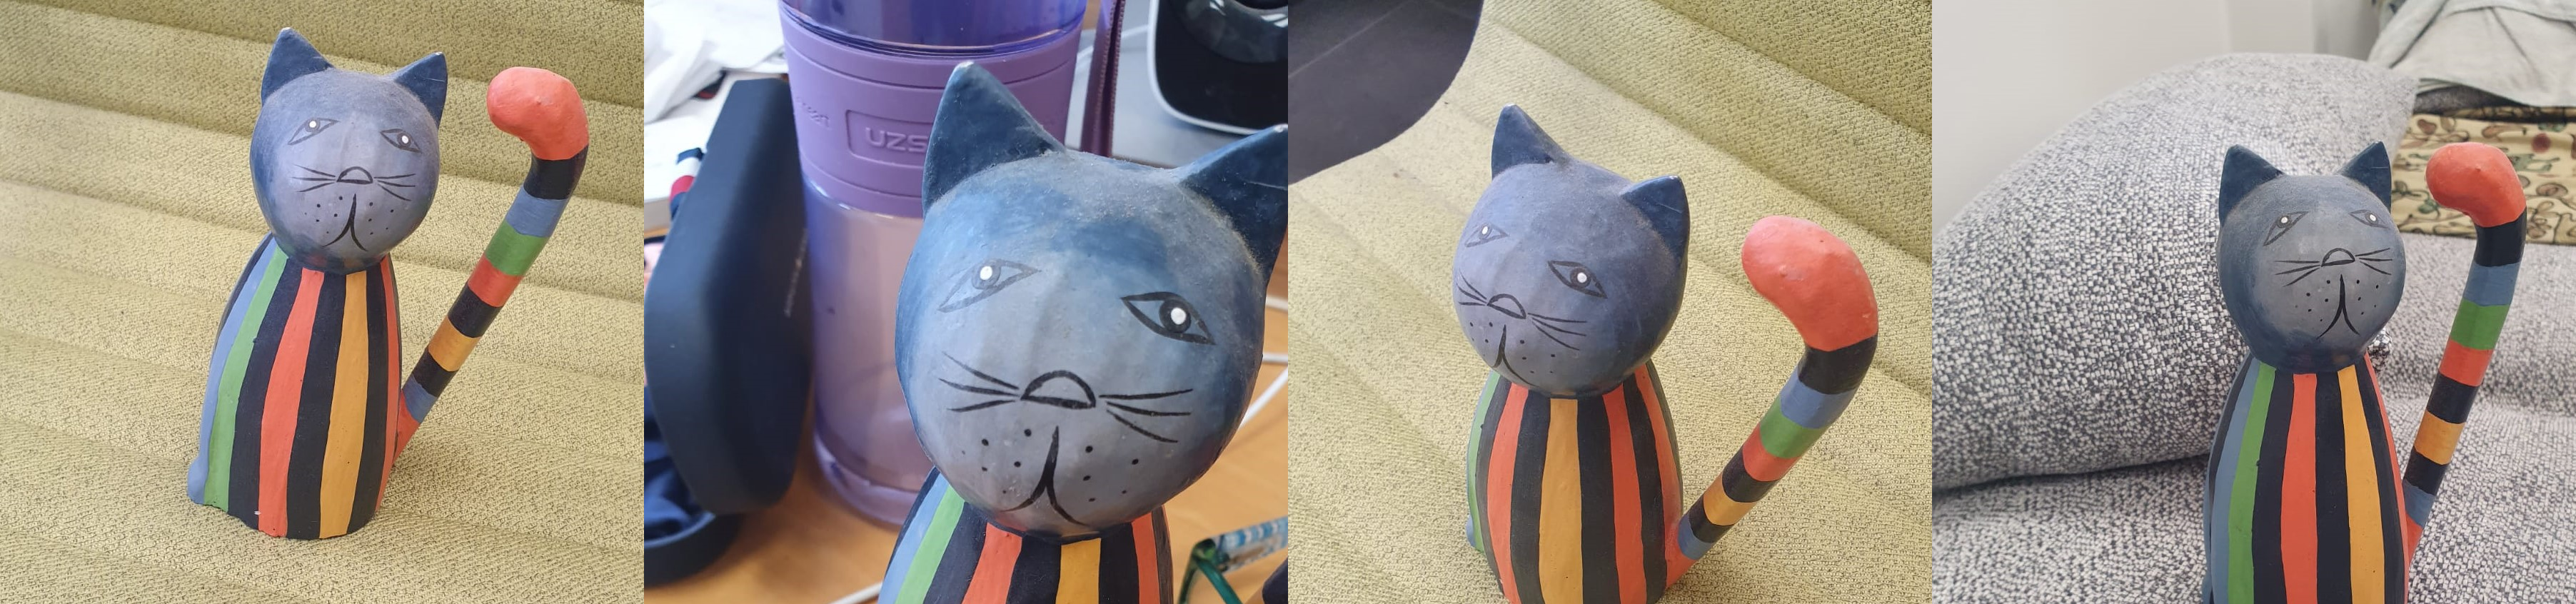

In [ ]:
def download_image(url):
  try:
    response = requests.get(url)
  except:
    return None
  return Image.open(BytesIO(response.content)).convert("RGB")

images = list(filter(None,[download_image(url) for url in urls]))
save_path = "./my_concept"
if not os.path.exists(save_path):
  os.mkdir(save_path)
[image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(images)]
image_grid(images, 1, len(images))


## Settings for your newly created concept





In [ ]:
instance_prompt = "<cat-toy> toy"
prior_preservation = False
prior_preservation_class_prompt = "a photo of a cat clay toy"

num_class_images = 12
sample_batch_size = 2
prior_loss_weight = 0.5
prior_preservation_class_folder = "./class_images"
class_data_root=prior_preservation_class_folder
class_prompt=prior_preservation_class_prompt


## Advanced settings for prior preservation

In [ ]:
num_class_images = 12
sample_batch_size = 2
prior_loss_weight = 1

prior_preservation_class_folder = "./class_images"
class_data_root=prior_preservation_class_folder


# Training the Model to Learn the New Concept Using DreamBooth

## Setup the Classes

In [ ]:
# Define the necessary classes for setting up the datasets

class DreamBoothDataset(Dataset):
    def __init__(
        self,
        instance_data_root,
        instance_prompt,
        tokenizer,
        class_data_root=None,
        class_prompt=None,
        size=512,
        center_crop=False,
    ):
        self.size = size
        self.center_crop = center_crop
        self.tokenizer = tokenizer

        self.instance_data_root = Path(instance_data_root)
        if not self.instance_data_root.exists():
            raise ValueError("Instance images root doesn't exist.")

        self.instance_images_path = list(self.instance_data_root.iterdir())
        self.num_instance_images = len(self.instance_images_path)
        self.instance_prompt = instance_prompt
        self._length = self.num_instance_images

        if class_data_root is not None:
            self.class_data_root = Path(class_data_root)
            self.class_data_root.mkdir(parents=True, exist_ok=True)
            self.class_images_path = list(self.class_data_root.iterdir())
            self.num_class_images = len(self.class_images_path)
            self._length = max(self.num_class_images, self.num_instance_images)
            self.class_prompt = class_prompt
        else:
            self.class_data_root = None

        self.image_transforms = transforms.Compose([
            transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ])

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        example = {}
        instance_image = Image.open(self.instance_images_path[index % self.num_instance_images])
        if instance_image.mode != "RGB":
            instance_image = instance_image.convert("RGB")
        example["instance_images"] = self.image_transforms(instance_image)
        example["instance_prompt_ids"] = self.tokenizer(
            self.instance_prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids

        if self.class_data_root:
            class_image = Image.open(self.class_images_path[index % self.num_class_images])
            if class_image.mode != "RGB":
                class_image = class_image.convert("RGB")
            example["class_images"] = self.image_transforms(class_image)
            example["class_prompt_ids"] = self.tokenizer(
                self.class_prompt,
                padding="do_not_pad",
                truncation=True,
                max_length=self.tokenizer.model_max_length,
            ).input_ids

        return example

class PromptDataset(Dataset):
    def __init__(self, prompt, num_samples):
        self.prompt = prompt
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        return {
            "prompt": self.prompt,
            "index": index,
        }


## Generate Class Images

In [ ]:
# Generate class images if prior preservation is enabled

if prior_preservation:
    class_images_dir = Path(class_data_root)
    if not class_images_dir.exists():
        class_images_dir.mkdir(parents=True)

    cur_class_images = len(list(class_images_dir.iterdir()))

    if cur_class_images < num_class_images:
        # Load the pre-trained Stable Diffusion pipeline
        pipeline = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name_or_path, revision="fp16", torch_dtype=torch.float16
        ).to("cuda")
        pipeline.enable_attention_slicing()
        pipeline.set_progress_bar_config(disable=True)

        num_new_images = num_class_images - cur_class_images
        print(f"Number of class images to sample: {num_new_images}.")

        sample_dataset = PromptDataset(class_prompt, num_new_images)
        sample_dataloader = torch.utils.data.DataLoader(sample_dataset, batch_size=sample_batch_size)

        # Generate and save class images
        for example in tqdm(sample_dataloader, desc="Generating class images"):
            images = pipeline(example["prompt"]).images
            for i, image in enumerate(images):
                image.save(class_images_dir / f"{example['index'][i] + cur_class_images}.jpg")

        # Cleanup
        pipeline = None
        gc.collect()
        del pipeline
        with torch.no_grad():
            torch.cuda.empty_cache()


## Load the Stable Diffusion model

In [ ]:
# Load models and create wrapper for stable diffusion
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet"
)
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/909 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

##Setting up all training args

In [ ]:
args = Namespace(
    pretrained_model_name_or_path=pretrained_model_name_or_path,
    resolution=vae.sample_size,
    center_crop=True,
    train_text_encoder=False,
    instance_data_dir=save_path,
    instance_prompt=instance_prompt,
    learning_rate=5e-06,
    max_train_steps=300,
    save_steps=50,
    mixed_precision="fp16", # set to "fp16" for mixed-precision training.
    gradient_checkpointing=True, # set this to True to lower the memory usage.
    use_8bit_adam=True, # use 8bit optimizer from bitsandbytes
    train_batch_size=2, # set to 1 if using prior preservation
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
    seed=3434554,
    with_prior_preservation=prior_preservation,
    prior_loss_weight=prior_loss_weight,
    sample_batch_size=2,
    class_data_dir=prior_preservation_class_folder,
    class_prompt=prior_preservation_class_prompt,
    num_class_images=num_class_images,
    lr_scheduler="constant",
    lr_warmup_steps=100,
    output_dir="dreambooth-concept",
)


<ipython-input-13-a3cde4a8edea>:3: FutureWarning: Accessing config attribute `sample_size` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'sample_size' over 'AutoencoderKL's config object instead, e.g. 'unet.config.sample_size'.
  resolution=vae.sample_size,


## Training function

In [ ]:
# Define the training function

def training_function(text_encoder, vae, unet):
    logger = get_logger(__name__)
    set_seed(args.seed)

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
    )

    # Ensure gradient accumulation is not used with distributed training
    if args.train_text_encoder and args.gradient_accumulation_steps > 1 and accelerator.num_processes > 1:
        raise ValueError(
            "Gradient accumulation is not supported when training the text encoder in distributed training. "
            "Please set gradient_accumulation_steps to 1. This feature will be supported in the future."
        )

    vae.requires_grad_(False)
    if not args.train_text_encoder:
        text_encoder.requires_grad_(False)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()
        if args.train_text_encoder:
            text_encoder.gradient_checkpointing_enable()

    # Use 8-bit Adam for optimization
    optimizer_class = bnb.optim.AdamW8bit if args.use_8bit_adam else torch.optim.AdamW
    params_to_optimize = (
        itertools.chain(unet.parameters(), text_encoder.parameters()) if args.train_text_encoder else unet.parameters()
    )
    optimizer = optimizer_class(params_to_optimize, lr=args.learning_rate)

    noise_scheduler = DDPMScheduler.from_config(args.pretrained_model_name_or_path, subfolder="scheduler")

    train_dataset = DreamBoothDataset(
        instance_data_root=args.instance_data_dir,
        instance_prompt=args.instance_prompt,
        class_data_root=args.class_data_dir if args.with_prior_preservation else None,
        class_prompt=args.class_prompt,
        tokenizer=tokenizer,
        size=args.resolution,
        center_crop=args.center_crop,
    )

    def collate_fn(examples):
        input_ids = [example["instance_prompt_ids"] for example in examples]
        pixel_values = [example["instance_images"] for example in examples]

        # Include class images and prompts if prior preservation is enabled
        if args.with_prior_preservation:
            input_ids += [example["class_prompt_ids"] for example in examples]
            pixel_values += [example["class_images"] for example in examples]

        pixel_values = torch.stack(pixel_values).to(memory_format=torch.contiguous_format).float()
        input_ids = tokenizer.pad(
            {"input_ids": input_ids},
            padding="max_length",
            return_tensors="pt",
            max_length=tokenizer.model_max_length
        ).input_ids

        return {"input_ids": input_ids, "pixel_values": pixel_values}

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.train_batch_size, shuffle=True, collate_fn=collate_fn
    )

    lr_scheduler = get_scheduler(
        args.lr_scheduler,
        optimizer=optimizer,
        num_warmup_steps=args.lr_warmup_steps * args.gradient_accumulation_steps,
        num_training_steps=args.max_train_steps * args.gradient_accumulation_steps,
    )

    if args.train_text_encoder:
        unet, text_encoder, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            unet, text_encoder, optimizer, train_dataloader, lr_scheduler
        )
    else:
        unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            unet, optimizer, train_dataloader, lr_scheduler
        )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    vae.to(accelerator.device, dtype=weight_dtype)
    vae.decoder.to("cpu")
    if not args.train_text_encoder:
        text_encoder.to(accelerator.device, dtype=weight_dtype)

    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {args.max_train_steps}")

    progress_bar = tqdm(range(args.max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample()
                latents *= 0.18215

                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device).long()
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                encoder_hidden_states = text_encoder(batch["input_ids"])[0]
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                target = noise if noise_scheduler.config.prediction_type == "epsilon" else noise_scheduler.get_velocity(latents, noise, timesteps)

                if args.with_prior_preservation:
                    noise_pred, noise_pred_prior = torch.chunk(noise_pred, 2, dim=0)
                    target, target_prior = torch.chunk(target, 2, dim=0)
                    loss = F.mse_loss(noise_pred.float(), target.float(), reduction="none").mean([1, 2, 3]).mean()
                    prior_loss = F.mse_loss(noise_pred_prior.float(), target_prior.float(), reduction="mean")
                    loss += args.prior_loss_weight * prior_loss
                else:
                    loss = F.mse_loss(noise_pred.float(), target.float(), reduction="mean")

                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    params_to_clip = (
                        itertools.chain(unet.parameters(), text_encoder.parameters())
                        if args.train_text_encoder
                        else unet.parameters()
                    )
                    accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()

            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

                if global_step % args.save_steps == 0 and accelerator.is_main_process:
                    pipeline = StableDiffusionPipeline.from_pretrained(
                        args.pretrained_model_name_or_path,
                        unet=accelerator.unwrap_model(unet),
                        text_encoder=accelerator.unwrap_model(text_encoder),
                    )
                    save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                    pipeline.save_pretrained(save_path)

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        accelerator.wait_for_everyone()

    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline.from_pretrained(
            args.pretrained_model_name_or_path,
            unet=accelerator.unwrap_model(unet),
            text_encoder=accelerator.unwrap_model(text_encoder),
        )
        pipeline.save_pretrained(args.output_dir)


## Run training

In [ ]:
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet))
for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
  if param.grad is not None:
    del param.grad  # free some memory
  torch.cuda.empty_cache()


Launching training on one GPU.


/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

  0%|          | 0/300 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

# Generating Images with the Fine-Tuned Model

## Set up the pipeline

In [ ]:
try:
    pipe
except NameError:
    pipe = StableDiffusionPipeline.from_pretrained(
        args.output_dir,
        scheduler = DPMSolverMultistepScheduler.from_pretrained(args.output_dir, subfolder="scheduler"),
        torch_dtype=torch.float16,
    ).to("cuda")


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

## Run the Stable Diffusion pipeline with interactive UI Demo on Gradio

In [ ]:
def inference(prompt, num_samples):
    all_images = []
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=25).images
    all_images.extend(images)
    return all_images

with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            prompt = gr.Textbox(label="prompt")
            samples = gr.Slider(label="Samples",value=1)
            run = gr.Button(value="Run")
        with gr.Column():
            gallery = gr.Gallery(show_label=False)

    run.click(inference, inputs=[prompt,samples], outputs=gallery)
    gr.Examples([["a photo of sks toy riding a bicycle", 1,1]], [prompt,samples], gallery, inference, cache_examples=False)


demo.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://3406e57a84609222ae.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## Run the Stable Diffusion pipeline on Colab

  0%|          | 0/25 [00:00<?, ?it/s]

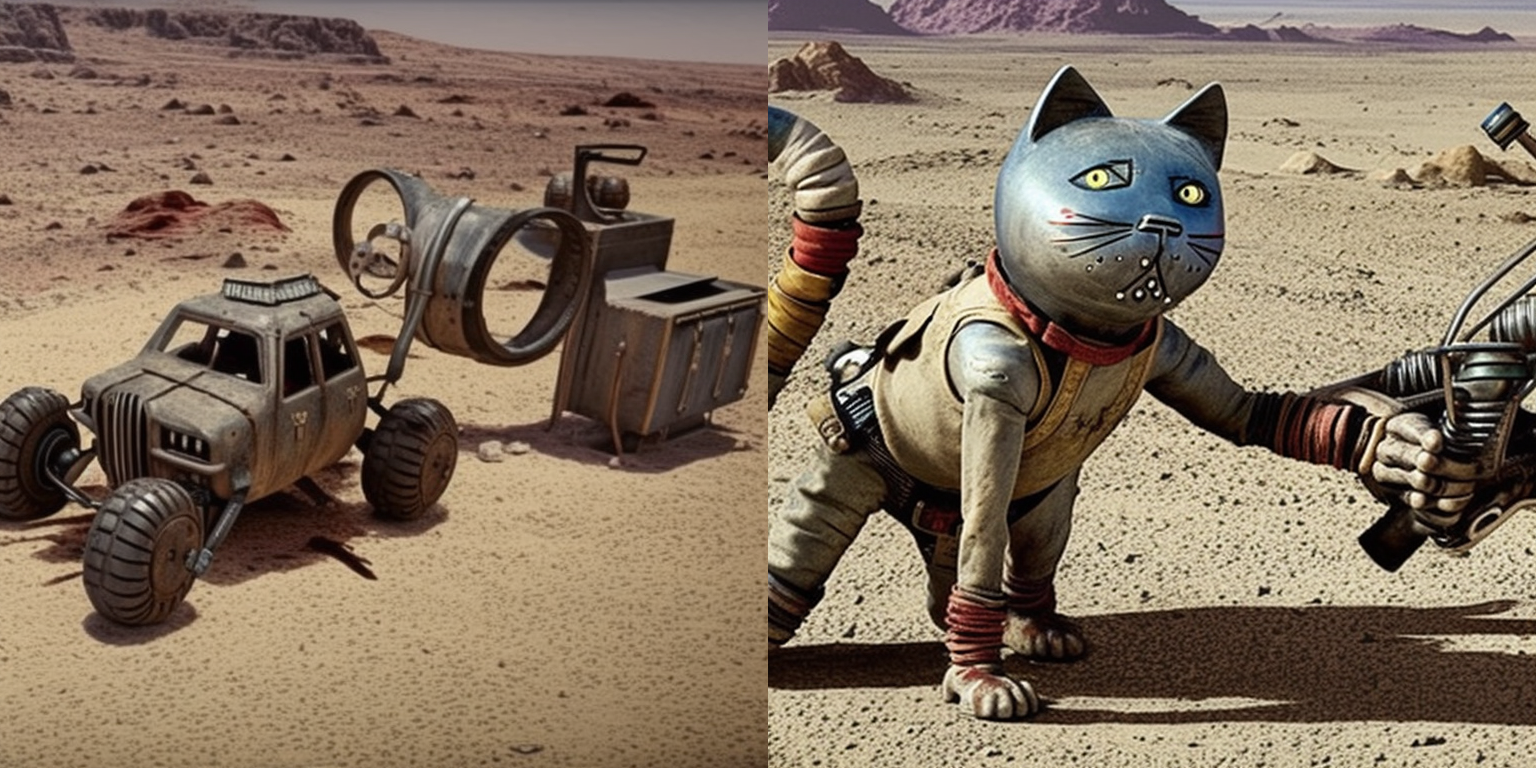

In [ ]:
prompt = "a \u003Ccat-toy> in mad max fury road"

num_samples = 2
num_rows = 1

all_images = []
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=25, guidance_scale=9).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid
